# A. Assignment details

- What: Download, manipulate and merge two or more datasets from below
- How: Create functions in a python file to do this
- Show: Show how to use these python files in a notebook

## 1.1 Download data

In [ ]:
import requests
import pandas as pd


api_key_un = "53408856aa4441c8af4cf29b62aab37a"

def get_uncomtrade_data(subscription_key: str, params: dict) -> pd.DataFrame:
    base_url = f"https://comtradeapi.un.org/data/v1/get/{params['typeCode']}/{params['freqCode']}/{params['clCode']}"
    query_params = {"subscription-key": subscription_key, **params}

    try:
        r = requests.get(base_url, params=query_params, timeout=60)
        r.raise_for_status()
        data = r.json()
        return pd.DataFrame(data["data"]) if data.get("data") else pd.DataFrame()
    except (requests.RequestException, ValueError) as err:
        print(f"Request failed: {err}")
        return pd.DataFrame()

# Initialize lists to store yearly results
dfs_china_import_from_us = []
dfs_us_import_from_china = []

for year in range(2020, 2024):  # 2020 to 2023 
    query_china = {
        "typeCode":  "C",
        "freqCode":  "A",
        "clCode":    "HS",
        "period": str(year),
        "reporterCode": "156",  # China
        "partnerCode": "842",   # US
        "flowCode":   "M",      # Imports
        "maxrecords": "1000",
        "cmdCode": "TOTAL"
    }

    query_us = {
        "typeCode":  "C",
        "freqCode":  "A",
        "clCode":    "HS",
        "period": str(year),
        "reporterCode": "842",  # US
        "partnerCode": "156",   # China
        "flowCode":   "M",      # Imports
        "maxrecords": "1000",
        "cmdCode": "TOTAL"
    }

    df_china = get_uncomtrade_data(api_key_un, query_china)
    df_us = get_uncomtrade_data(api_key_un, query_us)

    if not df_china.empty:
        dfs_china_import_from_us.append(df_china)

    if not df_us.empty:
        dfs_us_import_from_china.append(df_us)

# Combine all years
df_china_import_from_us = pd.concat(dfs_china_import_from_us, ignore_index=True)
df_us_import_from_china = pd.concat(dfs_us_import_from_china, ignore_index=True)

# Display summaries
print("\n📦 China Import from US 2020–2023")
print(df_china_import_from_us[['period', 'primaryValue']])

print("\n📦 US Import from China 2020–2023")
print(df_us_import_from_china[['period', 'primaryValue']])





📦 China Import from US 2020–2023
  period  primaryValue
0   2020  1.363395e+11
1   2021  1.797533e+11
2   2022  1.789568e+11
3   2023  1.651572e+11

📦 US Import from China 2020–2023
  period  primaryValue
0   2020  4.571642e+11
1   2021  5.415314e+11
2   2022  5.756881e+11
3   2023  4.480174e+11


In [ ]:
from fredapi import Fred

api_key_fred = 'a8be37f8d6242d8ee6601727cf359c50'
fred = Fred(api_key=api_key_fred)

def get_fred_series(series_id, start='2020-01-01', end='2023-12-31'):
    """
    Download annual data from FRED for a specific series between start and end dates.
    """
    data = fred.get_series(series_id)
    data = data.loc[start:end]
    df = data.resample('A').mean().reset_index()
    df.columns = ['year', series_id]
    df['year'] = df['year'].dt.year
    return df

series_ids = {
    'USA_GDP_per_capita': 'NYGDPPCAPKDUSA',  # Constant GDP per capita for US (World Bank)， 2010 USD
    'CHN_GDP_per_capita': 'NYGDPPCAPKDCHN',  # Constant GDP per capita for China (World Bank)， 2010 USD
    'USA_Youth_Unemployment': 'SLUEM1524ZSUSA',  # Youth Unemployment Rate, ages 15–24, US
    'CHN_Youth_Unemployment': 'SLUEM1524ZSCHN'   # Youth Unemployment Rate, ages 15–24, China
}

# Download each series
dfs = {}
for label, series_id in series_ids.items():
    dfs[label] = get_fred_series(series_id)
for df in dfs:
    print(dfs[df].head())

   year  NYGDPPCAPKDUSA
0  2020    59493.145982
1  2021    62996.289384
2  2022    64342.117938
3  2023    65875.177881
   year  NYGDPPCAPKDCHN
0  2020    10358.169997
1  2021    11223.255348
2  2022    11555.930238
3  2023    12175.196115
   year  SLUEM1524ZSUSA
0  2020          14.891
1  2021           9.704
2  2022           8.105
3  2023           7.953
   year  SLUEM1524ZSCHN
0  2020          12.678
1  2021          12.422
2  2022          14.811
3  2023          15.745


## 1.2 Manipulate Data

In [18]:
# Combine Fred data into one DataFrame
combined_fred = pd.concat(dfs.values(), axis=1)
combined_fred = combined_fred.loc[:,~combined_fred.columns.duplicated()]
combined_fred.rename(columns = {'NYGDPPCAPKDUSA':'GDP per capita US','NYGDPPCAPKDCHN':'GDP per capita China','SLUEM1524ZSUSA':'youth unemployment rate US','SLUEM1524ZSCHN':'youth unemployment rate China'}, inplace=True)
print(combined_fred)

df_china_import_from_us.rename(columns = {'primaryValue':'China import from US'}, inplace= True)
df_us_import_from_china.rename(columns = {'primaryValue':'US import from China'}, inplace= True)



   year  GDP per capita US  GDP per capita China  youth unemployment rate US  \
0  2020       59493.145982          10358.169997                      14.891   
1  2021       62996.289384          11223.255348                       9.704   
2  2022       64342.117938          11555.930238                       8.105   
3  2023       65875.177881          12175.196115                       7.953   

   youth unemployment rate China  
0                         12.678  
1                         12.422  
2                         14.811  
3                         15.745  


## 1.3 Merge Data and Plot

In [ ]:

df_china_import_from_us_sub, df_us_import_from_china_sub = df_china_import_from_us[['period','China import from US']], df_us_import_from_china[['period','US import from China']]
df_un = df_china_import_from_us_sub.merge(df_us_import_from_china_sub, on = ['period'], how = 'left')
df_un.dtypes
combined_fred['year'] = combined_fred['year'].astype(str)
df_final = df_un.merge(combined_fred, left_on=['period'], right_on=['year'], how = 'left')
df_final.drop(columns = ['period'], inplace=True)
df_final['China to US import ratio'], df_final['China to US youth unemployment rate ratio'], df_final['China to US gdp per capita ratio'] = \
  df_final['China import from US']/df_final['US import from China'],df_final['youth unemployment rate China']/df_final['youth unemployment rate US'],\
  df_final['GDP per capita China']/df_final['GDP per capita US']
df_final.describe()


,China import from US,US import from China,GDP per capita US,GDP per capita China,youth unemployment rate US,youth unemployment rate China,China to US import ratio,China to US youth unemployment rate ratio,China to US gdp per capita ratio
count,4.000000e+00,4.000000e+00,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,1.650517e+11,5.056003e+11,63176.682796,11328.137925,10.163250,13.914000,0.327415,1.484656,0.179172
std,2.028044e+10,6.288928e+10,2722.811050,757.459581,3.249827,1.623877,0.030800,0.518160,0.004427
min,1.363395e+11,4.480174e+11,59493.145982,10358.169997,7.953000,12.422000,0.298229,0.851387,0.174107
25%,1.579528e+11,4.548775e+11,62120.503533,11006.984010,8.067000,12.614000,0.307700,1.172915,0.177145
50%,1.720570e+11,4.993478e+11,63669.203661,11389.592793,8.904500,13.744500,0.321396,1.553741,0.178879
75%,1.791559e+11,5.500705e+11,64725.382924,11710.746708,11.000750,15.044500,0.341111,1.865482,0.180907
max,1.797533e+11,5.756881e+11,65875.177881,12175.196115,14.891000,15.745000,0.368640,1.979756,0.184822


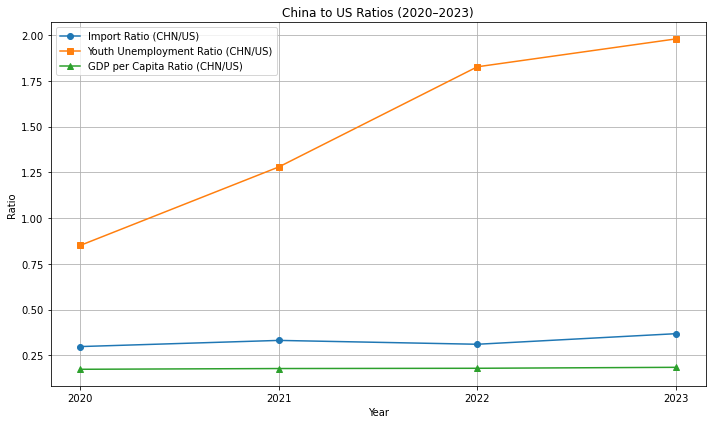

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_final['year'], df_final['China to US import ratio'], marker='o', label='Import Ratio (CHN/US)')
plt.plot(df_final['year'], df_final['China to US youth unemployment rate ratio'], marker='s', label='Youth Unemployment Ratio (CHN/US)')
plt.plot(df_final['year'], df_final['China to US gdp per capita ratio'], marker='^', label='GDP per Capita Ratio (CHN/US)')

plt.xlabel('Year')
plt.ylabel('Ratio')
plt.title('China to US Ratios (2020–2023)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()